# EDA insights

## Intro

In this notebook I will focus on questions related with Public Policy that could have been done by Government Institutions:

1. How the Colombian student population is distributed around the country?
2. 
3. 
4. 

_Note: these questions reflect my own ideas, or questions stated in docments shared by the owner of the project, and could be different of questions asked by Colombian public servants._

## Initial step
Import libraries, load and translate dataset.

In [1]:
# Import libraries

# basic libraries
import numpy as np
import pandas as pd
import re
# import ast
pd.set_option('display.max_rows', 500) # to show more rows.

# for translation
import sys
sys.path.append('../')
from Translate_data import translate_data

# to plot
import altair as alt
alt.renderers.enable('mimetype')

# root to call the data 
root = "../../../data/"

In [2]:
# Load Data
df = pd.read_csv(root + 'saber_combined_all_fields.csv')
df = df.drop(columns = 'Unnamed: 0')

In [3]:
# Translate data
df_eng = translate_data(df, 'spanish', 'english')

In [4]:
# Wrangling Municipality
import re
municipality_list = list(df_eng['cole_municipality_location'].unique()) + \
                    list(df_eng['your_municipality_resides'].unique()) + \
                    list(df_eng['your_inst_municipality'].unique()) + \
                    list(df_eng['your_municipality_resides.1'].unique())

municipality_list = pd.DataFrame(data=municipality_list, columns=['Name'])#.unique()
municipality_list = list(municipality_list.Name.unique())
municipality_list = [str(i) for i in municipality_list]
municipality_list = sorted(municipality_list)
municipality_values = sorted(municipality_list)

municipality_values = [re.sub(r'BOGOTÁ, D.C.', 'BOGOTÁ D.C.', mun) for mun in municipality_values]
municipality_values = [re.sub(r'CARTAGENA$', 'CARTAGENA DE INDIAS', mun) for mun in municipality_values]
municipality_values = [re.sub(r'CHIQUINQUIRÁ$', 'CHIQUINQUIRA', mun) for mun in municipality_values]
municipality_values = [re.sub(r'CIÉNEGA$', 'CIÉNAGA', mun) for mun in municipality_values]
municipality_values = [re.sub(r'PUERTO ASÍS$', 'PUERTO ASIS', mun) for mun in municipality_values]
municipality_values = [re.sub(r'POPAYÁN$', 'POPAYAN', mun) for mun in municipality_values]
municipality_values = [re.sub(r'FACATATIVÁ$', 'FACATATIVA', mun) for mun in municipality_values]

zip_iterator = zip(municipality_list, municipality_values) # Get pairs of elements
municipality_dict = dict(zip_iterator)  # Convert to dictionary

municipality_columns = ['cole_municipality_location', 'your_municipality_resides',
                        'your_inst_municipality', 'your_municipality_resides.1']

for col in municipality_columns:
    df_eng[col] = df_eng[col].map(municipality_dict)

In [5]:
df_eng.tail(3)

,your_type_of_document,your_nationality,your_gender,your_birthdate,your_foreigner,period,your_consecutive,your_marital_status,your_student,your_country_resides,...,score_biology_saber_11,score_chemistry_saber_11,score_physics_saber_11,score_social_science_saber_11,score_philosophy_saber_11,score_english_saber_11,score_english_saber_11_category,optative_field_saber_11,score_optative_saber_11,optative_category_saber_11
212007,CC,COLOMBIA,F,21/10/1971,NO,20183,EK201830110470,Married,STUDENT,COLOMBIA,...,43.0,29.0,46.0,40.0,34.0,38.0,A-,SCORE_INTERDISC_ENVIRONMENT,52.0,NaN
212008,CC,COLOMBIA,M,10/08/1994,NO,20183,EK201830148018,Single,STUDENT,COLOMBIA,...,42.0,46.0,45.0,44.0,33.0,43.0,A-,SCORE_INTERDISC_ENVIRONMENT,52.0,NaN
212009,CC,COLOMBIA,M,01/01/1997,NO,20183,EK201830033403,Single,STUDENT,COLOMBIA,...,57.0,61.0,56.0,69.0,69.0,50.0,A1,SCORE_DEEPEN_MATHEMATICS,6.0,II


## Answering questions:
### 1. how the Colombian student population is distributed around the country?
#### - - - Distribution by bar charts - - -


Number of Departments (States) in Colombia: 34 



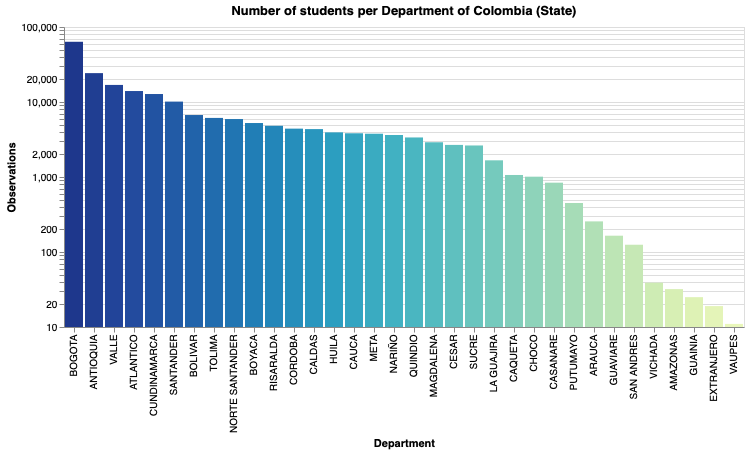

In [487]:
# Department of residence (Colombia states)
source = df_eng.groupby('your_dept_resides').count()[['your_consecutive']].reset_index().rename(columns={'your_consecutive':'obs'})
print("\nNumber of Departments (States) in Colombia:", len(source), "\n")

alt.Chart(source).mark_bar().encode(
    alt.X('your_dept_resides', sort='-y', title="Department"),
    alt.Y('obs', title="Observations", scale=alt.Scale(type='log')),
    alt.Color('your_dept_resides', legend=None, sort='-y', 
              scale=alt.Scale(scheme='yellowgreenblue', reverse=True)),
    tooltip=['your_dept_resides', 'obs']
).properties(
    title = "Number of students per Department of Colombia (State)"
)


Number of Municipalities in Colombia: 961 



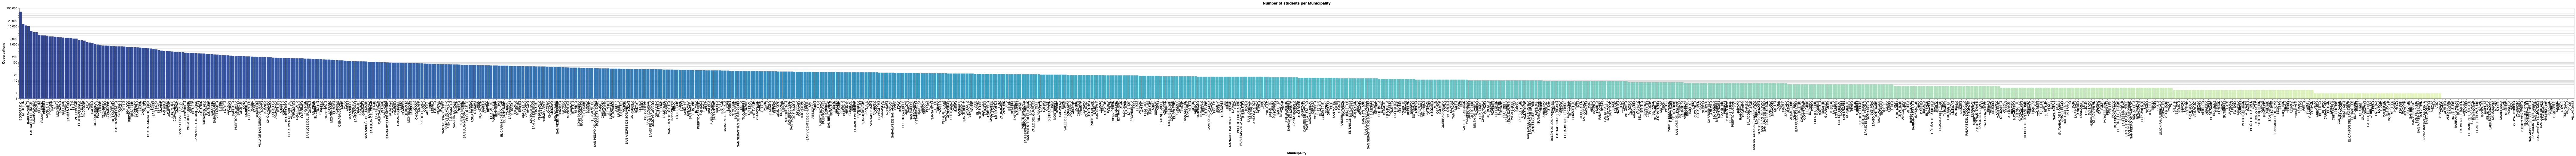

In [488]:
# Municipality
source = df_eng.groupby('your_municipality_resides').count()[['your_consecutive']].reset_index().rename(columns={'your_consecutive':'obs'})

print("\nNumber of Municipalities in Colombia:", len(source), "\n")

alt.Chart(source).mark_bar(opacity=0.9).encode(
    alt.X('your_municipality_resides', sort='-y', title="Municipality"),
    alt.Y('obs', title="Observations", scale=alt.Scale(type='log')),
    alt.Color('your_municipality_resides', legend=None, sort='-y',
             scale=alt.Scale(scheme='yellowgreenblue', reverse=True)),
    tooltip=['your_municipality_resides', 'obs']
).properties(
    width=8500,
    title = "Number of students per Municipality"
)

#### - - - Distribution by maps - - -

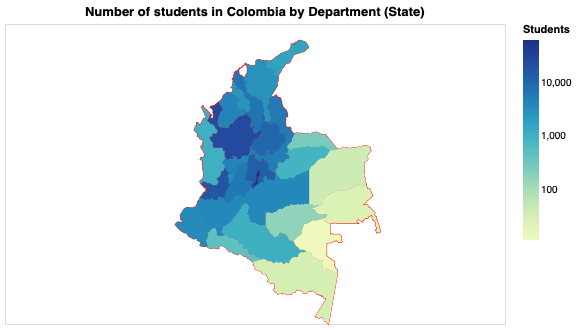

In [452]:
# Plot number of students in Colombia by Department (State)

### DATA ###
# States Polygons
states = alt.topo_feature(root + 'Colombia_departamentos_municipios_poblacion-topo.json', 'MGN_AMN_DPTOS') #MGN_AMN_MPIOS
states

# Dataframe of the project 'group by' for plotting
source = df_eng.groupby(['your_dept_resides', 'your_dept_code_resides']).\
        count()[['your_consecutive']].reset_index().rename(columns={'your_consecutive':'obs',
                                                                    'your_dept_resides': 'name',
                                                                    'your_dept_code_resides': 'code'})

### PLOT ###
# background
base_depart  = alt.Chart(states).mark_geoshape(
    fill='white',
    stroke='red'
).properties(
    width=500,
    height=300
)#.project('albersUsa')
background 

# find Department by code
plot_depart_by_code = alt.Chart(states).mark_geoshape().encode(
    alt.Color('obs:Q', scale=alt.Scale(type='log'), title="Students")
).transform_lookup(
    lookup='properties.DPTO_CCDGO',
    from_=alt.LookupData(data=source, key='code', fields=['obs'])
).properties(
    width=500,
    height=300
)

# find Department by Name
plot_depart_by_name = alt.Chart(states).mark_geoshape().encode(
    alt.Color('obs:Q', scale=alt.Scale(type='log'), title="Students")
).transform_lookup(
    lookup='properties.DPTO_CNMBR',
    from_=alt.LookupData(data=source, key='name', fields=['obs'])
).properties(
    width=500,
    height=300
)

# Integrate the plots
plot_depart = (base_depart + plot_depart_by_name + plot_depart_by_code)\
                    .properties(title="Number of students in Colombia by Department (State)")
plot_depart

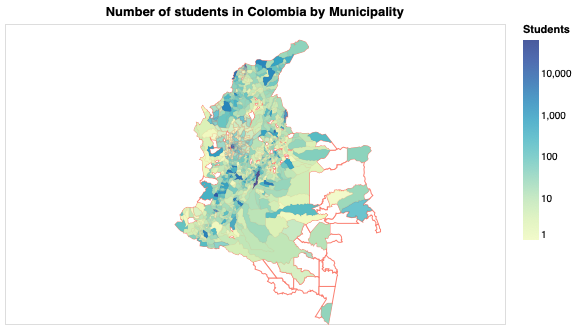

In [451]:
# Plot number of students in Colombia by Municipality

### DATA ###
# States Polygons
municipalities = alt.topo_feature(root + 'Colombia_departamentos_municipios_poblacion-topo.json', 'MGN_AMN_MPIOS') #MGN_AMN_MPIOS MGN_AMN_DPTOS
municipalities

# Dataframe of the project 'group by' for plotting
source = df_eng.groupby(['your_municipality_resides', 'your_municipality_code_resides']).\
        count()[['your_consecutive']].reset_index().rename(columns={'your_consecutive':'obs',
                                                                    'your_municipality_resides': 'name',
                                                                    'your_municipality_code_resides': 'code'})

### PLOT ###
# background
base_municip  = alt.Chart(municipalities).mark_geoshape(
    fill='white',
    stroke='salmon'
).properties(
    width=500,
    height=300
)#.project('albersUsa')
background 

# find Department by code
plot_municip_by_code = alt.Chart(municipalities).mark_geoshape(opacity=0.8).encode(
    alt.Color('obs:Q', scale=alt.Scale(type='log'), title="Students")
).transform_lookup(
    lookup='properties.MPIO_CDPMP',
    from_=alt.LookupData(data=source, key='code', fields=['obs'])
).properties(
    width=500,
    height=300
)

# find Department by Name
plot_municip_by_name = alt.Chart(municipalities).mark_geoshape(opacity=0.8).encode(
    alt.Color('obs:Q', scale=alt.Scale(type='log'), title="Students")
).transform_lookup(
    lookup='properties.MPIO_CNMBR',
    from_=alt.LookupData(data=source, key='name', fields=['obs'])
).properties(
    width=500,
    height=300
)

# Integrate the plots
plot_municip = (base_municip + plot_municip_by_name + plot_municip_by_code)\
                    .properties(title="Number of students in Colombia by Municipality")
plot_municip